<a href="https://colab.research.google.com/github/amita-rahma-permatasari/CNN/blob/main/UAS_SistemCerdas_Management_Waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Import Libraries***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
import pickle
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img


# ***Mounting Google Drive***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Import Dataset***

In [3]:
base_dir = "/content/drive/MyDrive/Garbage classification/Garbage classification"
target_size = (224, 224)

In [4]:
waste_labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

In [5]:
if os.path.exists(base_dir):
    print(f"The directory {base_dir} exists.")

    # List the contents of the directory
    print("Contents of the directory:")
    for item in os.listdir(base_dir):
        print(item)
else:
    print(f"The directory {base_dir} does not exist.")

The directory /content/drive/MyDrive/Garbage classification/Garbage classification exists.
Contents of the directory:
cardboard
glass
paper
plastic
trash
metal


# ***Load Dataset***

In [6]:
def load_dataset(path):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        x.append(img)
        label = image_path.split(os.path.sep)[-2]
        labels.append(waste_labels[label])

    x, labels = shuffle(x, labels, random_state=42)
    input_shape = (np.array(x[0]).shape[0], np.array(x[0]).shape[1], 3)

    print("X shape: ", np.array(x).shape)
    print(f"Number of Labels: {len(np.unique(labels))} , Number of Observations: {len(labels)}")
    print("Input Shape: ", input_shape)

    return np.array(x), np.array(labels), input_shape

In [7]:
x, labels, input_shape = load_dataset(base_dir)

X shape:  (2527, 224, 224, 3)
Number of Labels: 6 , Number of Observations: 2527
Input Shape:  (224, 224, 3)


In [8]:
x = x / 255.0

# ***Data Preparation***

In [9]:
def CNN_data_preparation():
  train = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
  test = ImageDataGenerator(rescale=1/255, validation_split=0.1)
  train_generator = train.flow_from_directory(directory=base_dir,
                                              target_size=(target_size),
                                              class_mode="categorical",
                                              subset="training")
  test_generator = test.flow_from_directory(directory=base_dir,
                                            target_size=(target_size),
                                            batch_size=251,
                                            class_mode="categorical",
                                            subset="validation")
  return train_generator, test_generator

In [10]:
train_generator, test_generator = CNN_data_preparation()

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [11]:
import os

total = 0
# Access the directory path from the DirectoryIterator object
for category in os.listdir(train_generator.directory):
    count= 0
    for image in os.listdir(os.path.join(train_generator.directory, category)):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))
print(f"\nTotal number of train images: {total}")

Cardboard: 403
Glass: 501
Paper: 594
Plastic: 482
Trash: 137
Metal: 410

Total number of train images: 2527


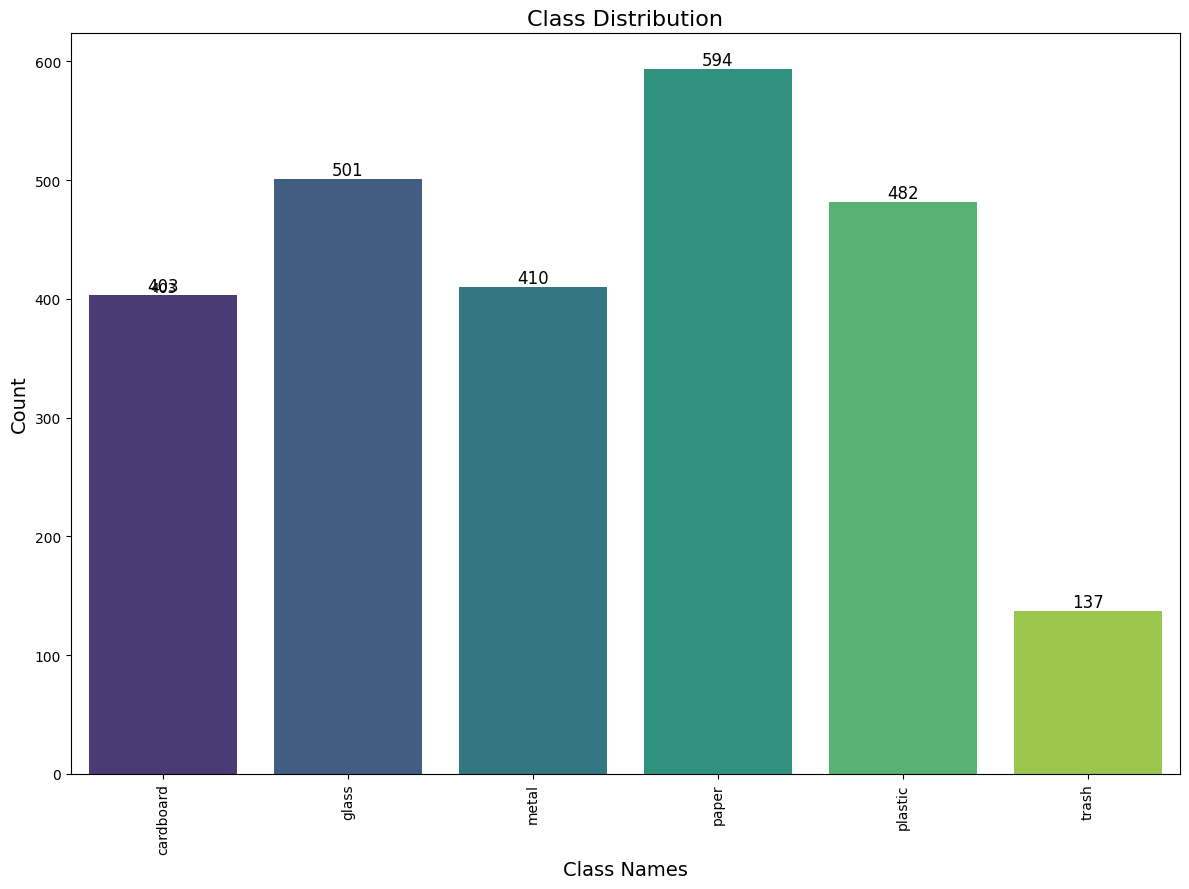

In [12]:
# Assuming 'train_generator' is defined and accessible from previous cells
class_names = list(train_generator.class_indices.keys())  # Get class names
class_dis = []  # Placeholder for class distribution

# Calculate class distribution
for category in class_names:
    category_path = os.path.join(train_generator.directory, category)
    count = len(os.listdir(category_path))
    class_dis.append(count)

# Create DataFrame
DF = pd.DataFrame({
    'Class names': class_names,
    'Count': class_dis
})

# Plot with color palette
plt.figure(figsize=(12, 9))
palette = sns.color_palette("viridis", len(class_names))  # You can change "viridis" to any other palette
ax = sns.barplot(x='Class names', y='Count', data=DF, palette=palette)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Add title and labels with explicit font sizes
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class Names', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add annotations for each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=12, color='black')

plt.tight_layout()
plt.show()

# ***Visualization Image***

In [13]:
def visualization_img(image_batch, labels, num_of_img):
  plt.figure(figsize=(10,10))
  for n in range(num_of_img):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
    plt.axis("off")

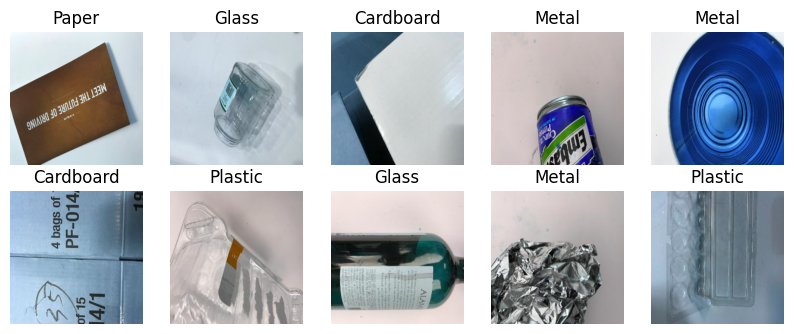

In [14]:
visualization_img(x, labels, 10)

# ***Modelling***

In [15]:
def CNN_create_and_fit_model(train_generator, test_generator, summary=True, fit=True, epochs=10):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Flatten())

  model.add(Dense(units=64, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=32, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=64, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=32, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=6, activation="softmax"))

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

  callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"),
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]

  if summary:
    model.summary()

  if fit:
    history = model.fit_generator(generator=train_generator, epochs=epochs, validation_data=test_generator,
                                callbacks=callbacks, workers=4, steps_per_epoch=700, validation_steps=251//32) # steps_per_epoch=2276//32, validation_steps=251//32
                                                                                                              # you can choose 2276/32 is 71 per epoch for best accuracy

  return model, history

In [16]:
model, history = CNN_create_and_fit_model(train_generator, test_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

# ***Evaluation***

In [17]:
def CNN_model_evaluate(model):
  loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)
  print("Test Accuracy: %.2f" % (100 * acc))
  print("Test Loss: %.2f" % (100 * loss))
  print("Test Precision: %.2f" % (100 * precision))
  print("Test Recall: %.2f" % (100 * recall))

  X_test, y_test = test_generator.next()
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(y_test, axis=1)
  target_names = list(waste_labels.keys())
  print(classification_report(y_test, y_pred, target_names=target_names))

  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  plt.plot(history.history["acc"], color="r", label="Training Accuracy")
  plt.plot(history.history["val_acc"], color="b", label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Accuracy", fontsize=16)
  plt.ylim([min(plt.ylim()),1])
  plt.title("Training and Validation Accuracy", fontsize=16)

  plt.subplot(1,2,2)
  plt.plot(history.history["loss"], color="r", label="Training Loss")
  plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16)

  return y_test, y_pred

1/1 [==============================] - 2s 2s/step - loss: 1.0821 - precision: 0.7413 - recall: 0.5936 - acc: 0.6614
Test Accuracy: 66.14
Test Loss: 108.21
Test Precision: 74.13
Test Recall: 59.36
8/8 [==============================] - 1s 91ms/step
              precision    recall  f1-score   support

   cardboard       0.52      0.82      0.64        40
       glass       0.87      0.66      0.75        50
       metal       0.62      0.56      0.59        41
       paper       0.74      0.93      0.83        59
     plastic       0.67      0.29      0.41        48
       trash       0.44      0.62      0.52        13

    accuracy                           0.66       251
   macro avg       0.64      0.65      0.62       251
weighted avg       0.68      0.66      0.65       251



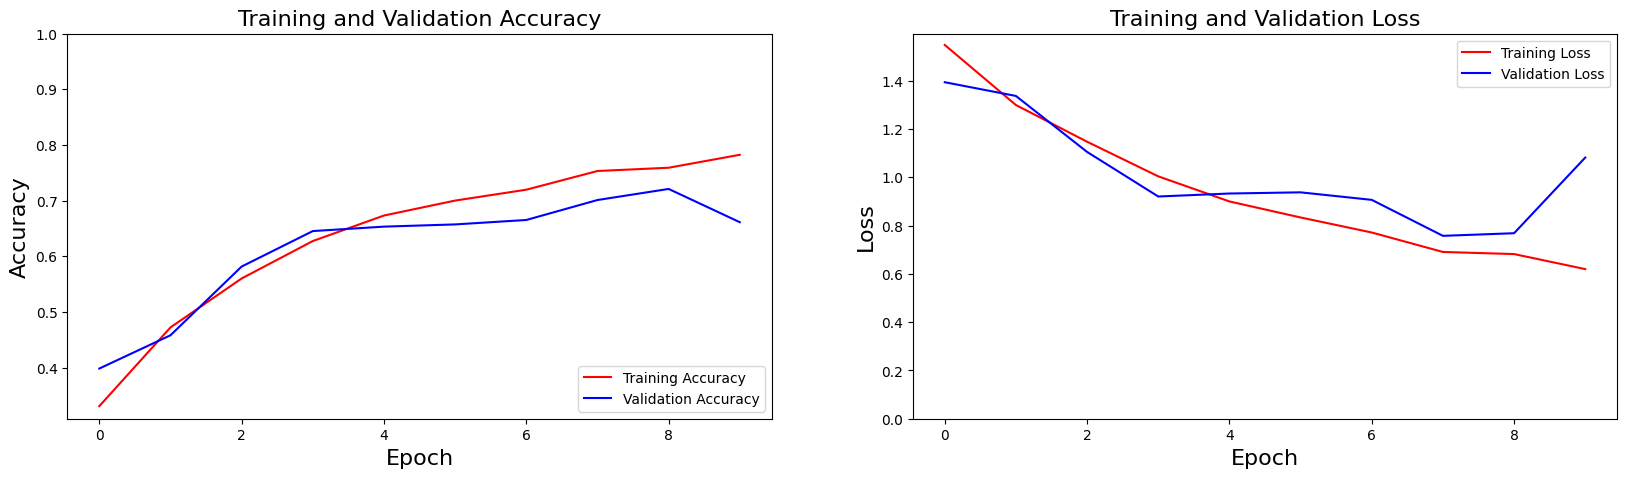

In [18]:
y_test, y_pred = CNN_model_evaluate(model)

# ***Confusion Matrix***

In [19]:
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.OrRd):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = ".2f" if normalize else "d"
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Labels", fontweight="bold")
  plt.xlabel("Predicted Labels", fontweight="bold")

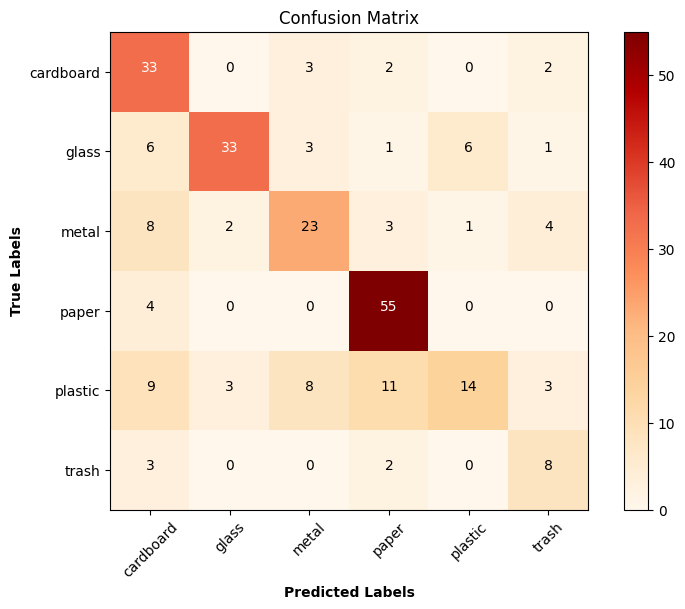

In [20]:
plot_confusion_matrix(cm, waste_labels.keys())

# ***Model Testing***

In [21]:
from keras.preprocessing import image
def CNN_model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0
  p = model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])
  return img, p, predicted_class

In [28]:
img, p, predicted_class = CNN_model_testing("/content/drive/MyDrive/Garbage classification/test2.jpg")


1/1 [==============================] - 0s 112ms/step


In [29]:
waste_labels = {0:"cardboard", 1:"glass", 2:"metal", 3:"paper", 4:"plastic", 5:"trash"}
def plot_model_testing(img, p, predicted_class):
  plt.axis("off")
  plt.imshow(img.squeeze())
  plt.title("Maximum Probabilty: " + str(np.max(p[0], axis=-1)) + "\n" + "Predicted Class: " + str(waste_labels[predicted_class]))
  plt.imshow(img);

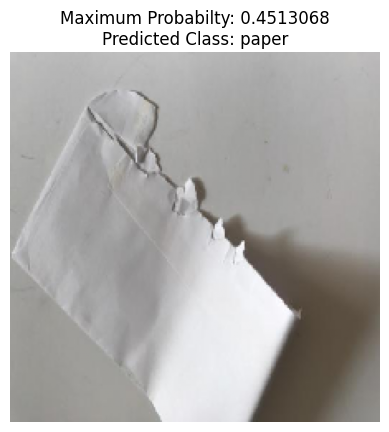

In [30]:
plot_model_testing(img, p, predicted_class)